In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

import sys
sys.path.insert(0,'..')

/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# 1. Load the data and get measurements

In [3]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 5

In [4]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [6]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (10, 2, 1001)
GT S-parameters shape:  (10, 2, 1001)
Y S-parameters shape:  (10, 2, 10)


In [7]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (1001,)
Y frequencies shape:  (10,)


In [8]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  1000000.0
Mean frequency spacing:  19999000.0
STD frequency spacing:  0.0
Mode frequency spacing:  19999000.0
Number of samples with non-equal spacing:  1


In [9]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [10]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  1001
N_SPARAMS:  10


In [11]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 20, 1001])


In [12]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 10, 1001])


## Plot some stuff

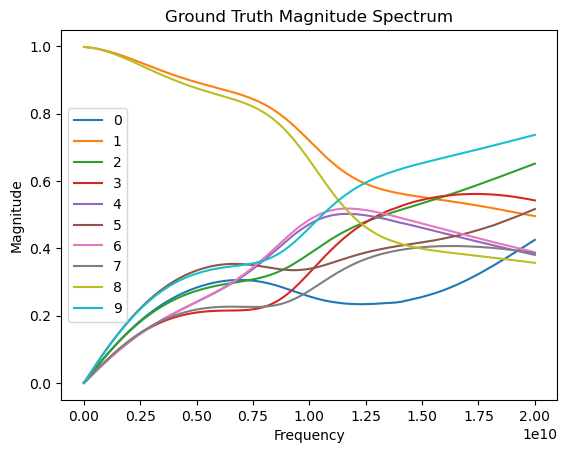

In [13]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

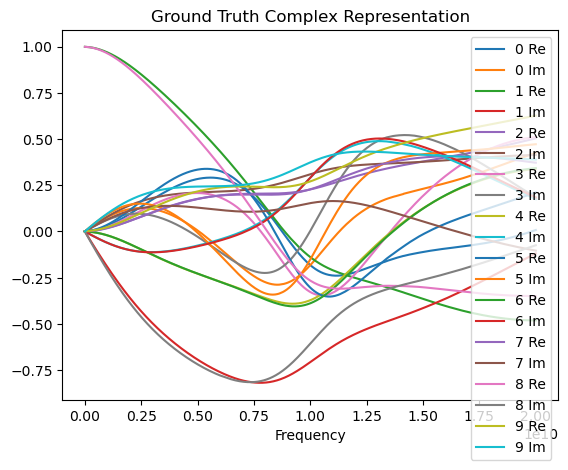

In [14]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [15]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 10

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)
old_kept = kept_inds.copy()

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

# remove every other point, starting at the back, don't remove first point
remove = False
for i in range(len(kept_inds) - 1, 0, -1):
    if remove:
        kept_inds = np.delete(kept_inds, [i])
        remove = False
    else:
        remove = True


print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)
print(old_kept)

Number of Ground Truth Frequency Points:  1001
Number of Measurements:  10
Undersampling Ratio:  0.00999000999000999
[   0  111  333  555  777 1000]
[   0  111  222  333  444  555  666  777  888 1000]


In [16]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 20, 6])
y_freqs shape:  (6,)


# 2. Network Setup

## Define network parameters

In [17]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = False

In [18]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  20
NUM_LAYERS:  6
BASE NGF:  64
NGF:  [64, 64, 64, 64, 64, 64]
BS:  1
NC:  20
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [19]:
from models import RES_UNET

ENSEMBLE_SIZE = 5

ensemble = [RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.0
               ) for i in range(ENSEMBLE_SIZE)]
for net in ensemble:
    net = net.to(device)

# Choose one network to visualize the results
net = ensemble[ENSEMBLE_SIZE // 2]

In [20]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 20, 1001])


/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [21]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  349384


# 3. Run

In [22]:
def find_max_variance(outputs, pickRandom=False):
    # Outputs of shape [ENSEMBLE_SIZE, 20, 1000]
    print("each output: ", outputs[0].shape)

    # Call np.var with dim = 0 to get shape [20, 1000]
    stacked_output = torch.cat(outputs, dim=0)
    print("after cat: ", stacked_output.shape)

    var_output = torch.var(stacked_output, dim=0)
    print("after var: ", var_output.shape)

    # Sum to go to [1000]
    var_output = torch.sum(var_output, dim=0)

    print("after sum: ", var_output.shape)

    if pickRandom:
        while True:
            rand_idx = random.randint(0, len(var_output) - 1)
            if rand_idx not in kept_inds:
                print("picked: ", rand_idx)
                return rand_idx

    _, idxs = torch.topk(var_output, len(var_output))

    for idx in idxs:
        if idx.item() not in kept_inds:
            return idx.item()
    return -1

## Define training parameters, losses, and track stats

In [23]:
#grab the correct file we want for VF
NUM_ACTIVE = M - len(kept_inds)

LR = 2e-4
FIRST_ITER = 20000
NUM_ITER = 2000
TOTAL_ITERS = FIRST_ITER + NUM_ITER * NUM_ACTIVE

REG_HYPERPARAM = 1.0
NOISY_INPUT = True

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optims = [torch.optim.Adam(ensemble[i].parameters(), lr=LR) for i in range(ENSEMBLE_SIZE)]
        
START_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS)
CUR_NOISE_LEVELS = [START_NOISE_LEVEL for i in range(ENSEMBLE_SIZE)]

ensemble_outputs = [None for i in range(ENSEMBLE_SIZE)]
ensemble_all_outputs = [[] for i in range(ENSEMBLE_SIZE)]
ensemble_train_losses = [[] for i in range(ENSEMBLE_SIZE)]
ensemble_train_errors = [[] for i in range(ENSEMBLE_SIZE)]
ensemble_train_regs = [[] for i in range(ENSEMBLE_SIZE)]
ensemble_test_mses = [[] for i in range(ENSEMBLE_SIZE)]
ensemble_test_maes = [[] for i in range(ENSEMBLE_SIZE)]

is_initial_fit = True
tic = time.time()
net.train()
print("NUM ACTIVE: ", NUM_ACTIVE)

CURR_ITER = FIRST_ITER

for num_actively_sampled in range(NUM_ACTIVE + 1):

    if not is_initial_fit:

        # Find the maximum standard deviation point, and use it to update kept_inds
        max_disagree_idx = find_max_variance(ensemble_outputs, pickRandom=False)
        kept_inds = np.sort(np.append(kept_inds, max_disagree_idx))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]

    for j, net in enumerate(ensemble):

        net.train()

        # Update the criterion to reflect the new point we have sampled
        criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
        criterion = criterion.to(device)
        optim = optims[j]
        train_losses = []
        train_errors = []
        train_regs = []
        test_mses = []
        test_maes = []

        for i in range(int(CURR_ITER)):
            optim.zero_grad()
            
            if NOISY_INPUT:
                out = net.forward_with_z(CUR_NOISE_LEVELS[j])
                CUR_NOISE_LEVELS[j] *= NOISE_DECAY_FACTOR
            else:
                out = net.forward_with_z()
            
            train_error = criterion(out, y) 
            if REG_HYPERPARAM > 0:
                train_reg = REG_HYPERPARAM * regularizer(out)
                train_loss = train_error + train_reg
            else:
                train_loss = train_error
            
            train_loss.backward()
            optim.step()

            with torch.no_grad():
                
                # Log the standard metrics across different numbers of samples given
                train_losses.append(train_loss.item())
                train_errors.append(train_error.item())
                if REG_HYPERPARAM > 0:
                    train_regs.append(train_reg.item())
                
                test_mse = nn.MSELoss()(out, x)
                test_mses.append(test_mse.item())
                
                test_mae = nn.L1Loss()(out, x)
                test_maes.append(test_mae.item())

                if (i+1)%1000 == 0 or i == 0:
                    toc = time.time()
                    print("ensemble idx: ", j)
                    print("ITER ", str(i))
                    print("TIME: ", str(toc - tic))
                    if NOISY_INPUT:
                        print("NOISE LEVEL: ", CUR_NOISE_LEVELS[j])
                    print()

        ensemble_outputs[j] = out
        ensemble_all_outputs[j].append(out)
        ensemble_train_losses[j].append(train_losses)
        ensemble_train_errors[j].append(train_errors)
        ensemble_train_regs[j].append(train_regs)
        ensemble_test_mses[j].append(test_mses)
        ensemble_test_maes[j].append(test_maes)

    if is_initial_fit :
        CURR_ITER = NUM_ITER
        is_initial_fit = False

print("NUM_SAMPLES ", str(num_actively_sampled))
print("TIME: ", str(toc - tic))


NUM ACTIVE:  4
ensemble idx:  0
ITER  0
TIME:  1.5821254253387451
NOISE LEVEL:  0.9997533248836328

ensemble idx:  0
ITER  999
TIME:  24.965601444244385
NOISE LEVEL:  0.7813707376517993

ensemble idx:  0
ITER  1999
TIME:  47.6075644493103
NOISE LEVEL:  0.6105402296585181

ensemble idx:  0
ITER  2999
TIME:  70.38611221313477
NOISE LEVEL:  0.4770582696143746

ensemble idx:  0
ITER  3999
TIME:  93.48569798469543
NOISE LEVEL:  0.37275937203147486

ensemble idx:  0
ITER  4999
TIME:  116.33662295341492
NOISE LEVEL:  0.2912632654908549

ensemble idx:  0
ITER  5999
TIME:  139.1181149482727
NOISE LEVEL:  0.22758459260746136

ensemble idx:  0
ITER  6999
TIME:  161.94668793678284
NOISE LEVEL:  0.17782794100387647

ensemble idx:  0
ITER  7999
TIME:  184.65199875831604
NOISE LEVEL:  0.13894954943729956

ensemble idx:  0
ITER  8999
TIME:  207.31457114219666
NOISE LEVEL:  0.10857111194020799

ensemble idx:  0
ITER  9999
TIME:  230.22402358055115
NOISE LEVEL:  0.0848342898243966

ensemble idx:  0
ITER

In [24]:
def bo_stack(list_list_tensor, squeeze=True):
    new_list = []
    for l in list_list_tensor:
        new_list.append(torch.stack(l))
    
    stacked = torch.stack(new_list)
    if squeeze:
        stacked = torch.squeeze(stacked)
    assert len(stacked.shape) == 4 # fuck
    return stacked

In [25]:
ensemble_outputs_stacked = bo_stack(ensemble_all_outputs)
# print(len(ensemble_train_losses[0][0]))
# print(len(ensemble_train_losses[-1]))
# train_losses = np.mean(ensemble_train_losses, axis=0).flatten()
# train_losses = np.concatenate(ensemble_train_losses)

train_losses_list = []
train_errors_list = []
test_maes_list = []
test_mses_list = []
for i in range(ENSEMBLE_SIZE):
    # print(len(ensemble_train_losses[i]))
    concat_list_losses = []
    concat_list_errors = []
    concat_list_maes = []
    concat_list_mses = []
    for j in range(len(ensemble_train_losses[i])):
        concat_list_losses.extend(ensemble_train_losses[i][j])
        concat_list_errors.extend(ensemble_train_errors[i][j])
        concat_list_maes.extend(ensemble_test_maes[i][j])
        concat_list_mses.extend(ensemble_test_mses[i][j])
    train_losses_list.append(concat_list_losses)
    train_errors_list.append(concat_list_errors)
    test_maes_list.append(concat_list_maes)
    test_mses_list.append(concat_list_mses)
train_losses = np.mean(train_losses_list, axis=0)
train_errors = np.mean(train_errors_list, axis=0)
test_maes = np.mean(test_maes_list, axis=0)
test_mses = np.mean(test_mses_list, axis=0)

# train_errors = np.mean(ensemble_train_errors, axis=0).flatten()
# test_maes = np.mean(ensemble_test_maes, axis=0).flatten()
# test_mses = np.mean(ensemble_test_mses, axis=0).flatten()

# Then, get the mean and variance of the actual output shape
# (1, S_PARAMS, FREQS)
out = torch.mean(torch.stack(ensemble_outputs), dim=0)
var_out = torch.var(torch.stack(ensemble_outputs), dim=0)

## Plot metrics and outputs

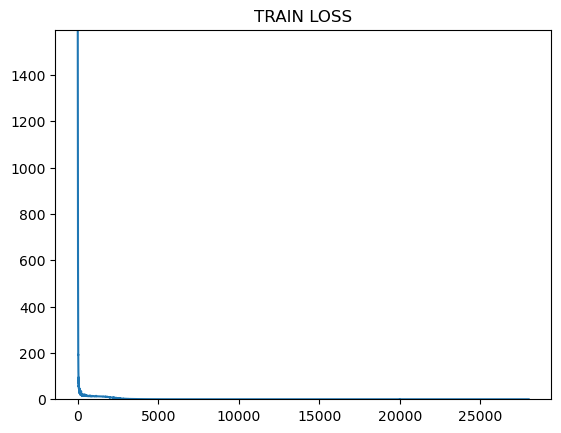

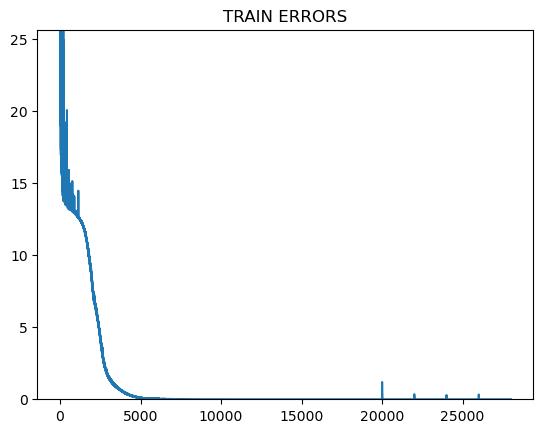

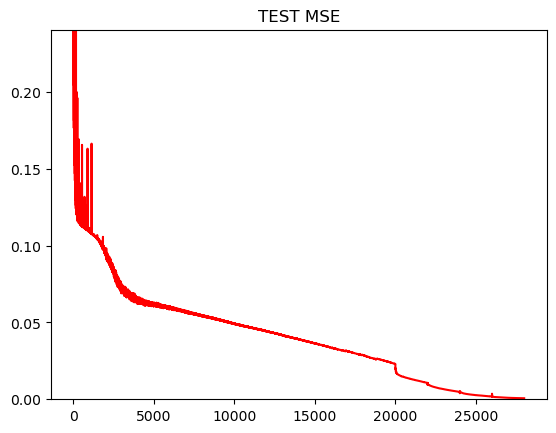

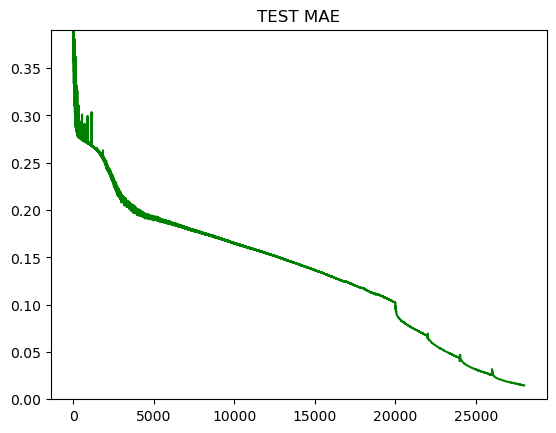

In [26]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [27]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.0006720048462739214
Best Test MSE:  0.0006717399432091042
Best Test MSE Iteration:  27998


In [28]:
# Make the VF Solution and use it as input to network
import VF.vectorfit
import os

LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case05/case05.s4p
[1.0000000e+06 2.2208890e+09 5.3007350e+09 6.6606670e+09 8.3205840e+09
 1.1100445e+10 1.3220339e+10 1.5540223e+10 1.6980151e+10 2.0000000e+10]
Performing fit with 1 poles.
  Fitting took 0.012307235971093178 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.029078440740704536 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 3 (err 0.0003714444860110907 vs 0.00630934651772299)
Fit completed in 0.13575434684753418, using 2, resulting in a fit with 4 and error=0.0003714444860110907 vs samples and error=0.0003714444860110907 vs ground truth.
(1001, 4, 4)
complex128
torch.Size([1, 20, 1001])


/u/bodeng/CurveFitting-DIP/ensemble_sampling_half/../VF/vectorfit.py:227: RuntimeWarning: Replacing d_res solution as it was too small. This is not a good sign and probably means that more starting poles are required
  vf.vector_fit(n_poles_cmplx=n_poles)
/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/skrf/vectorFitting.py:869: RuntimeWarning: invalid value encountered in sqrt
  for sqrt_eigenval in np.sqrt(P_eigs):
/u/bodeng/CurveFitting-DIP/ensemble_sampling_half/../VF/vectorfit.py:227: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit(n_poles_cmplx=n_poles)


In [29]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

print("Final DIP MSE: ", test_mses[-1])
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())
# print("Mean DIP MSE: ", nn.MSELoss()([-1][np.newaxis], x).item())

torch.Size([1001, 4, 4, 2])
torch.Size([1001, 4, 4, 2])
torch.Size([10, 4, 4, 2])
(1001, 4, 4, 2)
(1001, 4, 4, 2)
(10, 2, 1001)
(10, 2, 1001)
float32
float32
DIP PSNR:       39.183380517740154
VF PSNR:        53.553743726981736
Final DIP MSE:  0.0006720048462739214
VF MSE:         1.764759872457944e-05


(1001,)
torch.Size([1, 20, 1001])
torch.Size([1, 20, 10])
torch.Size([1, 20, 1001])
torch.Size([1, 20, 1001])


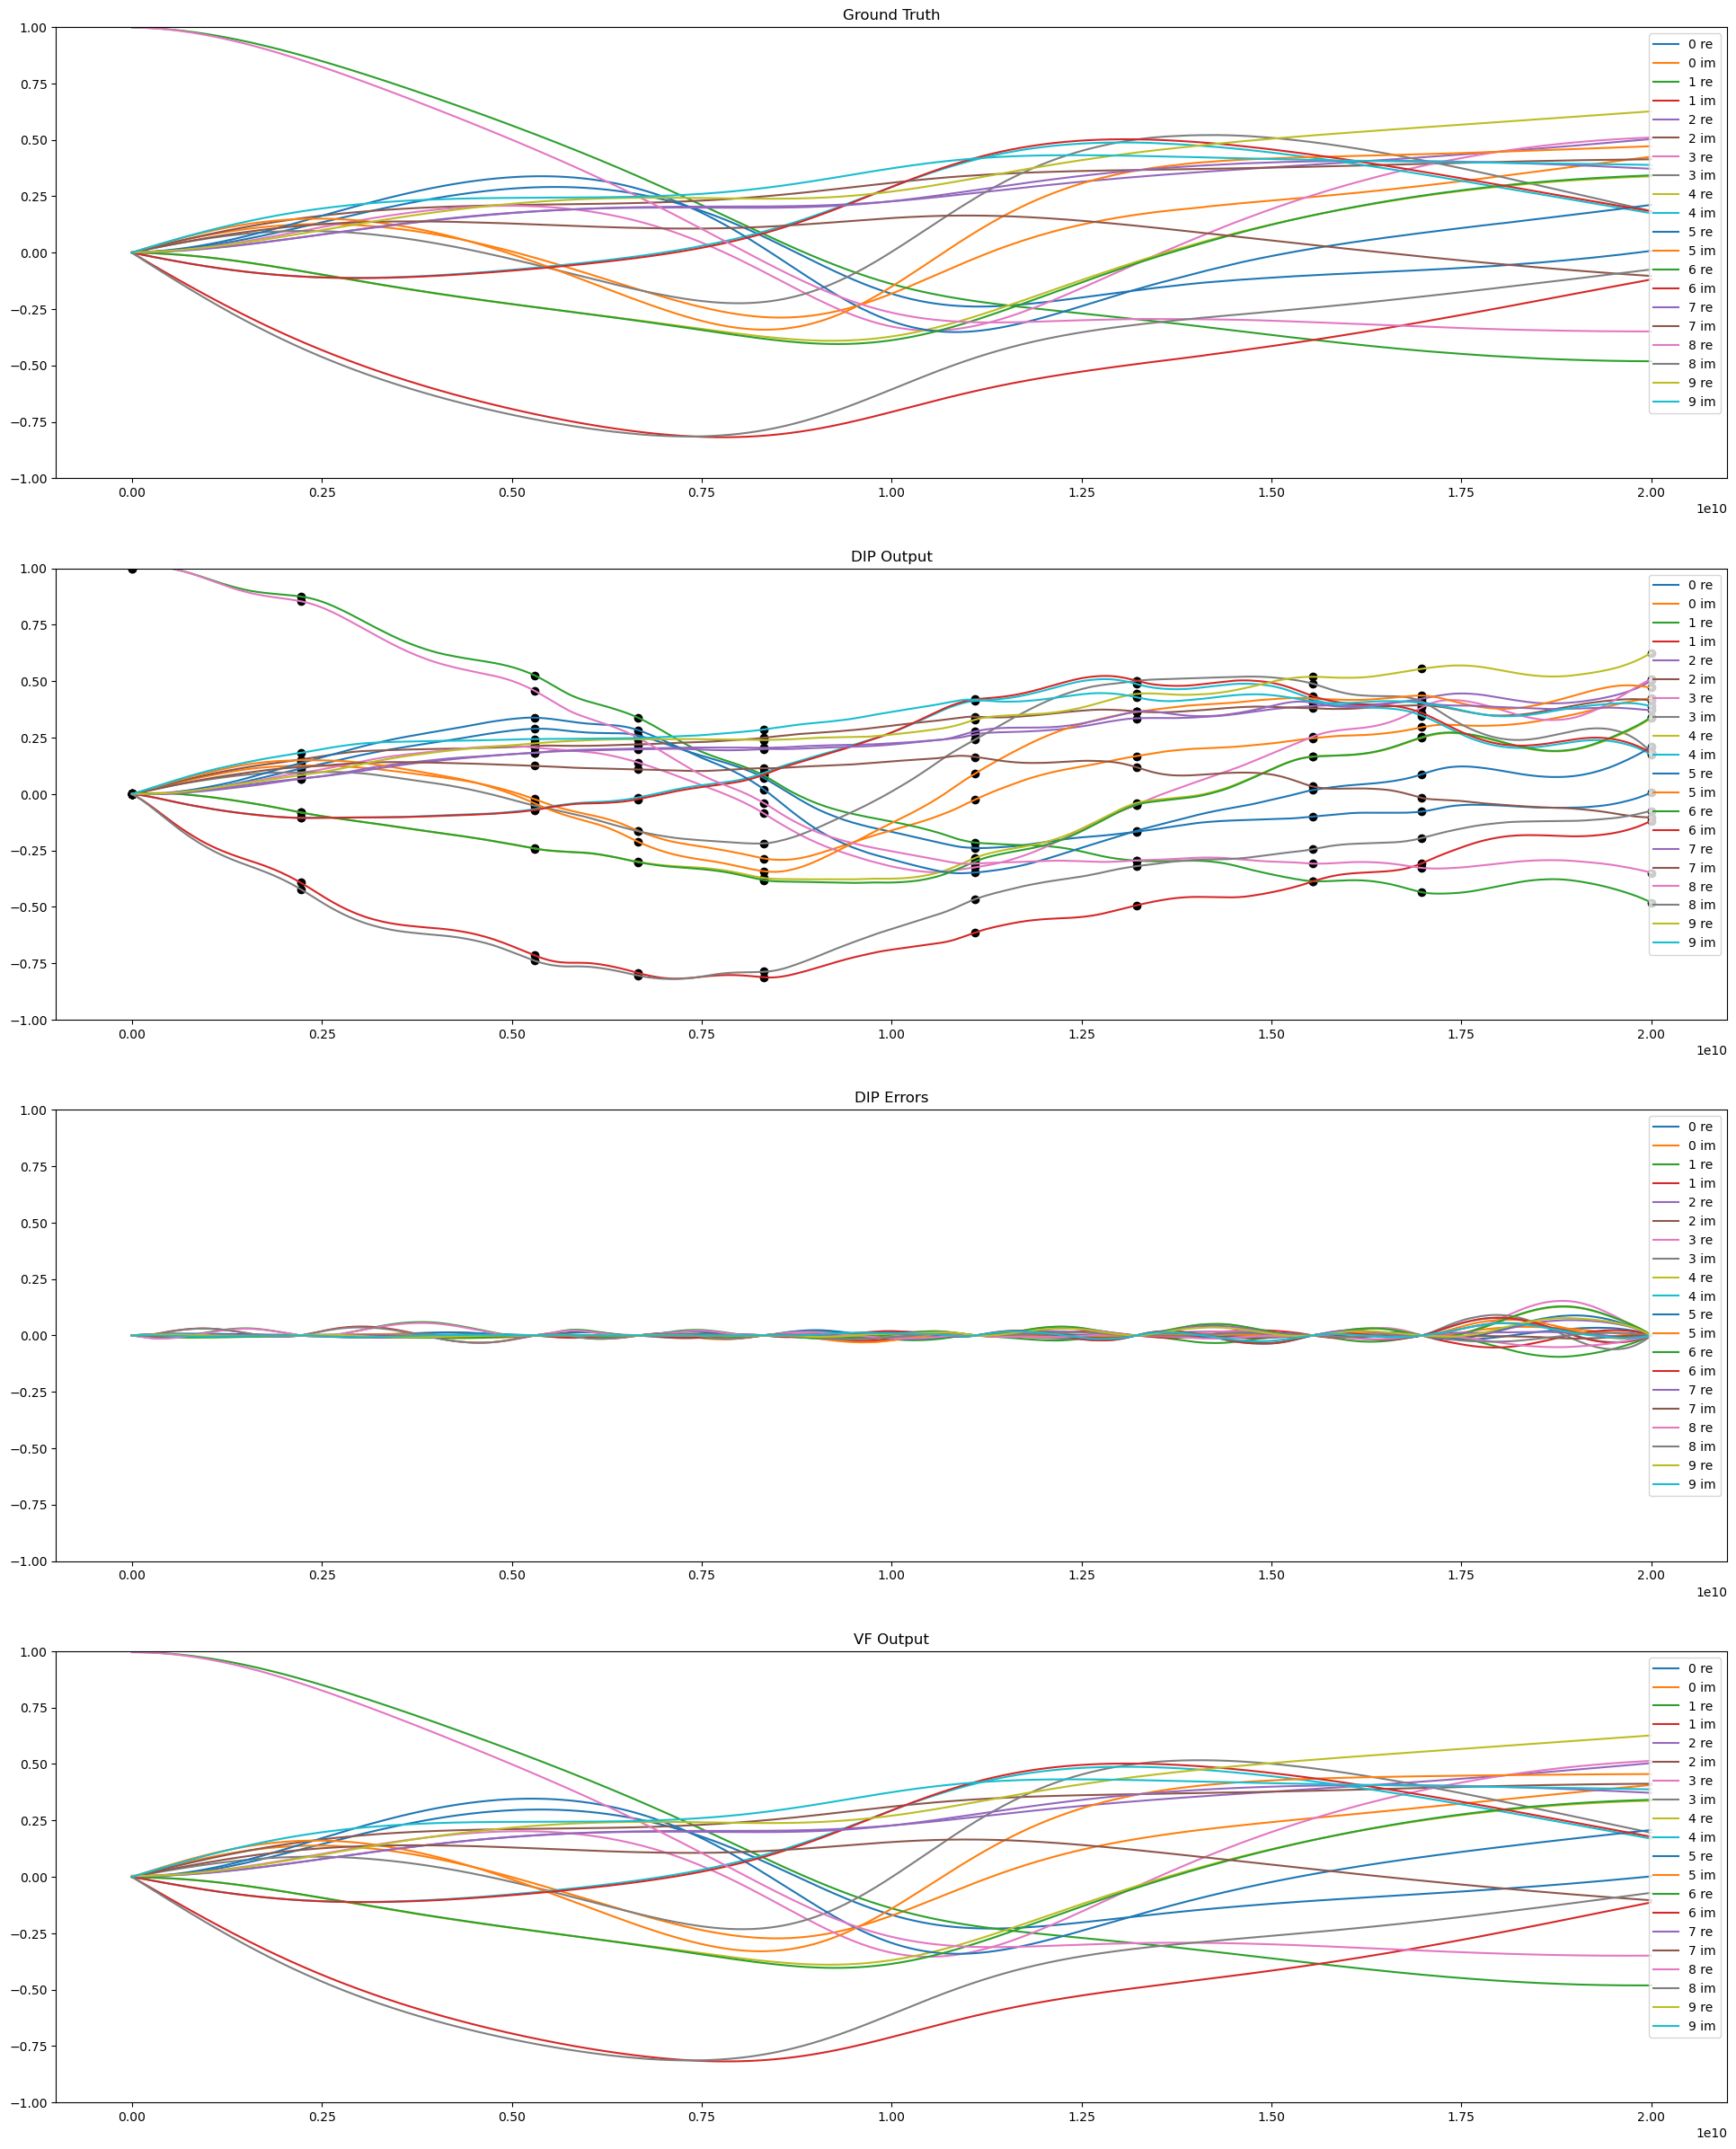

In [30]:
dip_errors = x.detach().cpu() - out.detach().cpu()
print(gt_freqs.shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")

    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')

axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

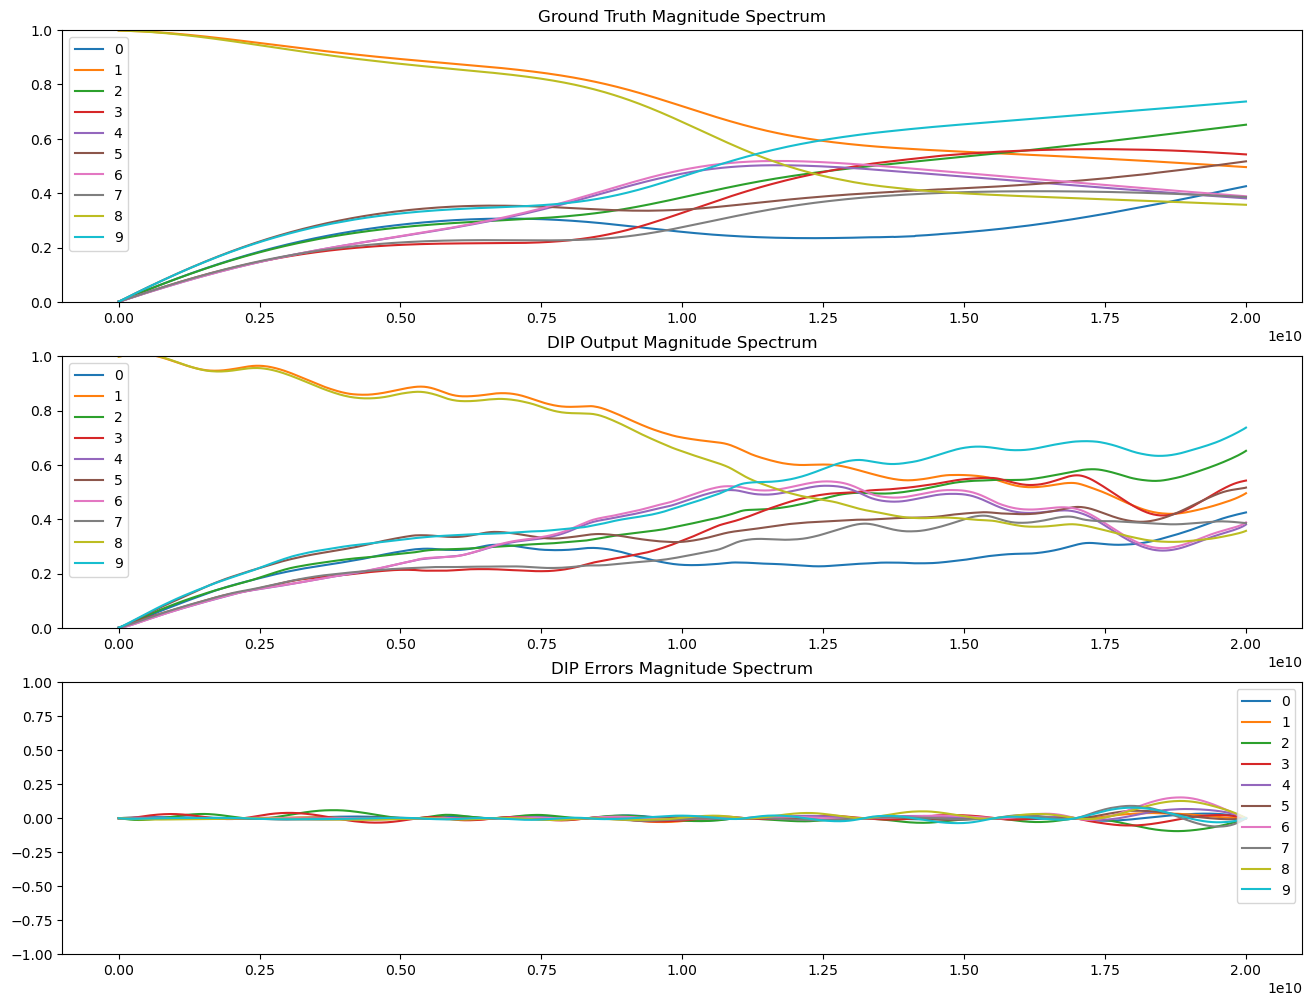

In [31]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [32]:
print(kept_inds)

[   0  111  265  333  416  555  661  777  849 1000]
